# Final Project

In [303]:
import os
import numpy as np
from numpy import arange
from numpy import absolute
from numpy import mean
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from IPython.display import Image
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xg
from prettytable import PrettyTable

In [304]:
full_data = pd.read_csv("model_data.csv")
gk_df = pd.read_csv("gk_df.csv")
field_df = pd.read_csv("field_df.csv")

## Split GK / Field

In [305]:
#create goalkeeper dataframe by selecting players with corresponding position index
gk_df = full_data[full_data.position_dummy == 1]
gk_df = gk_df[["long_name","age", "height_cm", "weight_kg", "value_eur", "gk_diving", "gk_handling", "gk_kicking", "gk_reflexes", "gk_speed", "gk_positioning", "movement_acceleration", "movement_sprint_speed", "movement_agility", "movement_reactions", "movement_balance", "power_shot_power", "power_jumping", "power_stamina", "power_strength", "power_long_shots", "mentality_vision", "mentality_penalties", "mentality_composure", "number_of_traits"]]

In [306]:
field_df = full_data[full_data.position_dummy != 1]
field_df = field_df.drop(["Unnamed: 0", "sofifa_id", "gk_diving", "gk_handling", "gk_kicking", "gk_reflexes", "gk_speed", "gk_positioning", "international_reputation", "position_dummy", "preferred_foot"],axis=1)

In [307]:
#for later processing, create dictionaries containing players name/age and respective index in base dataframe
name_gk = list(gk_df.long_name)
index_gk = list(gk_df.index)
gk_zip_iter = zip(index_gk, name_gk)
gk_dict = dict(gk_zip_iter)

name_field = list(field_df.long_name)
index_field = list(field_df.index)
field_zip_iter = zip(index_field, name_field)
field_dict = dict(field_zip_iter)

In [308]:
age_gk = list(gk_df.age)
gk_age_zip_iter = zip(index_gk, age_gk)
gk_age_dict = dict(gk_age_zip_iter)
gk_df= gk_df.drop(["long_name"], axis=1)

age_field = list(field_df.age)
field_age_zip_iter = zip(index_field, age_field)
field_age_dict = dict(field_age_zip_iter)
field_df = field_df.drop(["long_name"],axis = 1)

In [309]:
gk_df = gk_df.astype(float)
field_df = field_df.astype(float)

## Random Forest Regression for Goalkeepers

In [310]:
#data and target values are set for the goalkeeper data
X = gk_df.drop("value_eur",axis=1)
y = gk_df.value_eur

In [311]:
#train and test sets are formed
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 1/3, random_state = 42)

In [312]:
#hyperparameter tuning dictionary initiated
tuned_parameters = {'n_estimators': [100, 200, 300], 'max_depth': [None, 1, 2], 'criterion': ['mse']}
#hyperparameter tuning performed
clf = GridSearchCV(RandomForestRegressor(random_state=0), tuned_parameters, cv=3, verbose=1)

In [313]:
#the best model is fit to the train data
clf.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=0),
             param_grid={'criterion': ['mse'], 'max_depth': [None, 1, 2],
                         'n_estimators': [100, 200, 300]},
             verbose=1)

In [314]:
#the best model hyperparameters
clf.best_params_

{'criterion': 'mse', 'max_depth': None, 'n_estimators': 300}

In [315]:
#test values are predicted with the trained model
y_pred=clf.predict(X_test)
#some metrics are output
mean_squared_error(y_test,y_pred,squared=True), mean_squared_error(y_test,y_pred,squared=False)

(0.07389963250961852, 0.2718448684629131)

In [316]:
#r square value for the model
clf.score(X_test,y_test)

0.965785290466796

Feature 0 (age): 0.079653
Feature 1 (height_cm): 0.001421
Feature 2 (weight_kg): 0.001372
Feature 3 (gk_diving): 0.127801
Feature 4 (gk_handling): 0.033519
Feature 5 (gk_kicking): 0.002053
Feature 6 (gk_reflexes): 0.698488
Feature 7 (gk_speed): 0.001001
Feature 8 (gk_positioning): 0.025394
Feature 9 (movement_acceleration): 0.001401
Feature 10 (movement_sprint_speed): 0.001254
Feature 11 (movement_agility): 0.001680
Feature 12 (movement_reactions): 0.010433
Feature 13 (movement_balance): 0.001489
Feature 14 (power_shot_power): 0.001453
Feature 15 (power_jumping): 0.001590
Feature 16 (power_stamina): 0.001560
Feature 17 (power_strength): 0.001674
Feature 18 (power_long_shots): 0.001343
Feature 19 (mentality_vision): 0.001763
Feature 20 (mentality_penalties): 0.001389
Feature 21 (mentality_composure): 0.001869
Feature 22 (number_of_traits): 0.000402


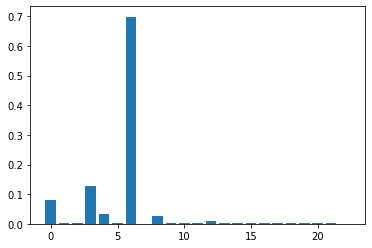

In [317]:
# feature importances are plotted
for i in range(len(clf.best_estimator_.feature_importances_)):
	print('Feature %d (%s): %f' % (i, X.columns[i], clf.best_estimator_.feature_importances_[i]))
# plot the scores
plt.bar([i for i in range(len(clf.best_estimator_.feature_importances_))], clf.best_estimator_.feature_importances_)
plt.show()

In [318]:
#all evaluation metrics defined
gk_mse_rf = mean_squared_error(y_test,y_pred,squared=True)
gk_rmse_rf = mean_squared_error(y_test,y_pred,squared=False)
gk_mae_rf = mean_absolute_error(y_test,y_pred)
gk_mape_rf = mean_absolute_percentage_error(y_test,y_pred)
gk_r2_rf = clf.score(X_test, y_test)
gk_mse_rf, gk_rmse_rf, gk_mae_rf, gk_mape_rf

(0.07389963250961852,
 0.2718448684629131,
 0.19971588852398334,
 0.015719622001950977)

In [319]:
#back transformation of the logged target variables and logged predictions
y_pred_real=np.e**y_pred
y_test_real=np.e**y_test

In [320]:
#new dataframe is created with only player indexed, real target and predictions
list_of_indexes = list(y_test.index)
list_of_predictions = list(y_pred_real)
list_total = list(zip(list_of_indexes, list(y_test_real), list_of_predictions))
df_gk_rf = pd.DataFrame(list_total, columns = ['index', 'true', 'pred'])

In [321]:
#adding two columns to the new datadrame for evaluation. Difference column is for the absolute difference between the real and predicted values.
df_gk_rf["Difference"] = df_gk_rf.pred-df_gk_rf.true
#the different percentage column is for the percentage difference between the real and predicted values.
df_gk_rf['Difference %'] = 100*(df_gk_rf.pred-df_gk_rf.true)/df_gk_rf.true

In [322]:
#adding the name column to the new dataframe by matching player indexes
name_list = []
for index in list(y_test.index):
    if index in gk_dict:
        name_list.append(gk_dict[index])
    else:
        break
df_gk_rf['player'] = name_list
col = df_gk_rf.pop("player")
df_gk_rf.insert(0, col.name, col)

In [323]:
#adding the age column to the new dataframe by matching player indexes
age_list = []
for index in list(y_test.index):
    if index in gk_age_dict:
        age_list.append(gk_age_dict[index])
    else:
        break
df_gk_rf['age'] = age_list
col = df_gk_rf.pop("age")
df_gk_rf.insert(0, col.name, col)

In [324]:
#sorting the absolute difference for final evaluation
df_gk_rf.sort_values(by='Difference',ascending=False)

,age,player,index,true,pred,Difference,Difference %
22,28,Miguel Kaíque Acuna Mutto,6126,775000.0,7.033142e+06,6.258142e+06,807.502160
227,30,Alexandros Paschalakis,2986,2700000.0,6.892094e+06,4.192094e+06,155.262725
109,33,Franco Armani,485,8000000.0,1.149935e+07,3.499354e+06,43.741928
580,32,Agustín Federico Marchesín,261,13500000.0,1.622168e+07,2.721682e+06,20.160607
119,34,Guilherme Alvim Marinato,791,4500000.0,7.003336e+06,2.503336e+06,55.629689
...,...,...,...,...,...,...,...
559,24,André Onana,110,30000000.0,2.630211e+07,-3.697893e+06,-12.326311
324,32,Raphael William Anjos Rochedo,270,13500000.0,8.461125e+06,-5.038875e+06,-37.324998
313,23,Unai Simón Mendibil,375,15500000.0,1.024965e+07,-5.250354e+06,-33.873253
337,25,Kepa Arrizabalaga Revuelta,218,21000000.0,1.315138e+07,-7.848617e+06,-37.374369


In [325]:
#sorting the percentage difference for final evaluation
df_gk_rf.sort_values(by='Difference %',ascending=False)

,age,player,index,true,pred,Difference,Difference %
22,28,Miguel Kaíque Acuna Mutto,6126,775000.0,7.033142e+06,6.258142e+06,807.502160
137,24,Luciano Renato Cacheira Sá,6119,800000.0,2.059805e+06,1.259805e+06,157.475587
227,30,Alexandros Paschalakis,2986,2700000.0,6.892094e+06,4.192094e+06,155.262725
401,22,Peter Morrison,17182,90000.0,1.980841e+05,1.080841e+05,120.093461
649,40,Kyriakos Stamatopoulos,16830,10000.0,2.032916e+04,1.032916e+04,103.291566
...,...,...,...,...,...,...,...
301,19,Adrián Rodríguez Giménez,14496,375000.0,1.934743e+05,-1.815257e+05,-48.406856
521,20,Ștefan Târnovanu,13783,475000.0,2.210313e+05,-2.539687e+05,-53.467086
581,30,Jorge Bladimir Pinos Haiman,2683,3100000.0,1.412849e+06,-1.687151e+06,-54.424222
43,28,Enzo Wellington Marteiro Santoso,2399,4100000.0,1.789319e+06,-2.310681e+06,-56.358069


Text(0.5, 1.0, 'Distribution of Residuals, Random Forest, Goalkeeper Dataset')

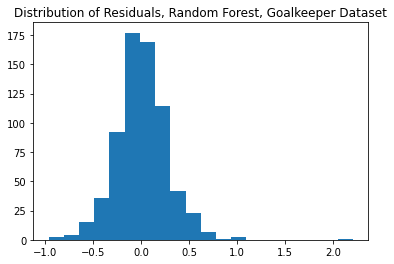

In [326]:
#residuals are plotted
plt.hist(y_pred-y_test,bins=20)
plt.title('Distribution of Residuals, Random Forest, Goalkeeper Dataset')

### XGBoost Regression for Goalkeepers

In [327]:
#XGBoost Regressor is initiated
xgb1 = xg.XGBRegressor()
#parameters are set for hyperparameter tuning
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [0.01,0.03, 0.05], #so called `eta` value
              'max_depth': [4,5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500],
                'reg_alpha': [0,1,2]}
#hyperparameter tuning with GridSearchCV
xgb_grid_gk = GridSearchCV(xgb1,
                        parameters,
                        cv = 5,
                        n_jobs = 5,
                        verbose=True)
#train set is fitted to the best model
xgb_grid_gk.fit(X_train, y_train,early_stopping_rounds=10, eval_set=[(X_test, y_test)])

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[0]	validation_0-rmse:12.2105
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:11.8463
[2]	validation_0-rmse:11.4929
[3]	validation_0-rmse:11.1503
[4]	validation_0-rmse:10.8192
[5]	validation_0-rmse:10.4978
[6]	validation_0-rmse:10.1853
[7]	validation_0-rmse:9.88139
[8]	validation_0-rmse:9.58696
[9]	validation_0-rmse:9.3025
[10]	validation_0-rmse:9.0258
[11]	validation_0-rmse:8.75772
[12]	validation_0-rmse:8.49702
[13]	validation_0-rmse:8.24385
[14]	validation_0-rmse:7.99822
[15]	validation_0-rmse:7.76088
[16]	validation_0-rmse:7.52964
[17]	validation_0-rmse:7.30649
[18]	validation_0-rmse:7.08932
[19]	validation_0-rmse:6.87823
[20]	validation_0-rmse:6.67365
[21]	validation_0-rmse:6.47479
[22]	validation_0-rmse:6.28112
[23]	validation_0-rmse:6.09524
[24]	validation_0-rmse:5.91465
[25]	validation_0-rmse:5.73919
[26]	validation_0-rmse:5.56955
[27]	validation_0-rmse:5.40468
[28]	validation_0

[252]	validation_0-rmse:0.188444
[253]	validation_0-rmse:0.188317
[254]	validation_0-rmse:0.188325
[255]	validation_0-rmse:0.188194
[256]	validation_0-rmse:0.188125
[257]	validation_0-rmse:0.188021
[258]	validation_0-rmse:0.187964
[259]	validation_0-rmse:0.187834
[260]	validation_0-rmse:0.187738
[261]	validation_0-rmse:0.187709
[262]	validation_0-rmse:0.187753
[263]	validation_0-rmse:0.187721
[264]	validation_0-rmse:0.187657
[265]	validation_0-rmse:0.187543
[266]	validation_0-rmse:0.187357
[267]	validation_0-rmse:0.187147
[268]	validation_0-rmse:0.187054
[269]	validation_0-rmse:0.186819
[270]	validation_0-rmse:0.186626
[271]	validation_0-rmse:0.186591
[272]	validation_0-rmse:0.186537
[273]	validation_0-rmse:0.186491
[274]	validation_0-rmse:0.186345
[275]	validation_0-rmse:0.186285
[276]	validation_0-rmse:0.186101
[277]	validation_0-rmse:0.185894
[278]	validation_0-rmse:0.185834
[279]	validation_0-rmse:0.185735
[280]	validation_0-rmse:0.185591
[281]	validation_0-rmse:0.185529
[282]	vali

GridSearchCV(cv=5, estimator=XGBRegressor(), n_jobs=5,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.01, 0.03, 0.05],
                         'max_depth': [4, 5, 6, 7], 'min_child_weight': [4],
                         'n_estimators': [500], 'nthread': [4],
                         'objective': ['reg:squarederror'],
                         'reg_alpha': [0, 1, 2], 'silent': [1],
                         'subsample': [0.7]},
             verbose=True)

In [328]:
#hyperparameters for the best model
xgb_grid_gk.best_estimator_

XGBRegressor(colsample_bytree=0.7, learning_rate=0.03, max_depth=4,
             min_child_weight=4, n_estimators=500, nthread=4,
             objective='reg:squarederror', silent=1, subsample=0.7)

In [329]:
#the test set is predicted on the model
y_pred=xgb_grid_gk.predict(X_test)

In [330]:
xgb_grid_gk.best_estimator_

XGBRegressor(colsample_bytree=0.7, learning_rate=0.03, max_depth=4,
             min_child_weight=4, n_estimators=500, nthread=4,
             objective='reg:squarederror', silent=1, subsample=0.7)

In [331]:
#evaluation metris are defined
gk_mse_xgb = mean_squared_error(y_test,y_pred,squared=True)
gk_rmse_xgb = mean_squared_error(y_test,y_pred,squared=False)
gk_mae_xgb = mean_absolute_error(y_test,y_pred)
gk_mape_xgb = mean_absolute_percentage_error(y_test,y_pred)
gk_r2_xgb = xgb_grid_gk.best_estimator_.score(X_test,y_test)
gk_mse_xgb, gk_rmse_xgb,gk_mae_xgb,gk_mape_xgb,gk_r2_xgb

(0.0313541415548585,
 0.17707100709844767,
 0.13200954257203323,
 0.010420446964403257,
 0.9854833805050003)

In [332]:
#the predictions are transformed from log to real values
y_pred_real=np.e**y_pred

In [333]:
#new dataframe is created with only player indexed, real target and predictions
list_of_indexes = list(y_test.index)
list_of_predictions = list(y_pred_real)
list_total = list(zip(list_of_indexes, list(y_test_real), list_of_predictions))
df_gk_xgb = pd.DataFrame(list_total, columns = ['index', 'true', 'pred'])

In [334]:
#adding two columns to the new datadrame for evaluation. Difference column is for the absolute difference between the real and predicted values.
df_gk_xgb["Difference"] = df_gk_xgb.pred-df_gk_xgb.true
#the different percentage column is for the percentage difference between the real and predicted values.
df_gk_xgb['Difference %'] = 100*(df_gk_xgb.pred-df_gk_xgb.true)/df_gk_xgb.true

In [335]:
name_list = []
for index in list(y_test.index):
    if index in gk_dict:
        name_list.append(gk_dict[index])
    else:
        break
df_gk_xgb['player'] = name_list
col = df_gk_xgb.pop("player")
df_gk_xgb.insert(0, col.name, col)

In [336]:
age_list = []
for index in list(y_test.index):
    if index in gk_age_dict:
        age_list.append(gk_age_dict[index])
    else:
        break
df_gk_xgb['age'] = age_list
col = df_gk_xgb.pop("age")
df_gk_xgb.insert(0, col.name, col)

In [337]:
df_gk_xgb.sort_values(by='Difference',ascending=False)

,age,player,index,true,pred,Difference,Difference %
285,29,Kevin Trapp,188,18500000.0,23157426.00,4657426.00,25.175276
580,32,Agustín Federico Marchesín,261,13500000.0,17577368.00,4077368.00,30.202726
32,31,Jordi Masip López,342,11500000.0,13942314.00,2442314.00,21.237513
24,29,Luigi Sepe,1064,6500000.0,8720518.00,2220518.00,34.161815
289,28,Gerónimo Rulli,225,20000000.0,22084078.00,2084078.00,10.420390
...,...,...,...,...,...,...,...
246,27,Walter Daniel Benítez,301,15500000.0,14191293.00,-1308707.00,-8.443271
94,26,Matt Turner,2145,5000000.0,3080063.25,-1919936.75,-38.398735
313,23,Unai Simón Mendibil,375,15500000.0,13511705.00,-1988295.00,-12.827710
337,25,Kepa Arrizabalaga Revuelta,218,21000000.0,16358147.00,-4641853.00,-22.104062


In [338]:
df_gk_xgb[df_gk_xgb['age']<23].sort_values(by='Difference',ascending=False)

,age,player,index,true,pred,Difference,Difference %
470,20,Ailton Nuno Cardenhas Macedo,4376,1800000.0,2768837.500,968837.500,53.824306
400,20,Jairo Ralph Farnias Almeida,5251,1400000.0,2291092.500,891092.500,63.649464
553,20,Illan Meslier,5320,1500000.0,2039229.125,539229.125,35.948608
265,22,Altay Bayındır,2508,4300000.0,4702389.000,402389.000,9.357884
642,22,Sebastián Jurado Roca,6360,1000000.0,1316921.625,316921.625,31.692163
...,...,...,...,...,...,...,...
256,20,Kjell Scherpen,7192,1400000.0,1080410.250,-319589.750,-22.827839
185,20,Diogo Meireles Costa,4444,2600000.0,2079090.375,-520909.625,-20.034986
67,20,Lucas Luciano Mantela Patrício,1135,7000000.0,6365615.000,-634385.000,-9.062643
115,22,Aleksandr Maksimenko,2452,5000000.0,4140648.500,-859351.500,-17.187030


In [339]:
#sorting the percentage difference for final evaluation
df_gk_xgb.sort_values(by='Difference %',ascending=False)

,age,player,index,true,pred,Difference,Difference %
137,24,Luciano Renato Cacheira Sá,6119,800000.0,1.827394e+06,1.027394e+06,128.424203
22,28,Miguel Kaíque Acuna Mutto,6126,775000.0,1.497113e+06,7.221129e+05,93.175855
496,28,Caio Rodrigo Padricio Resende,6157,775000.0,1.461285e+06,6.862849e+05,88.552887
680,19,Juan Carlos González Quintero,18562,35000.0,6.501289e+04,3.001289e+04,85.751116
401,22,Peter Morrison,17182,90000.0,1.606637e+05,7.066372e+04,78.515243
...,...,...,...,...,...,...,...
94,26,Matt Turner,2145,5000000.0,3.080063e+06,-1.919937e+06,-38.398735
482,22,Maarten Paes,4480,2300000.0,1.395565e+06,-9.044349e+05,-39.323255
98,21,Didier Desprez,14600,375000.0,2.221604e+05,-1.528396e+05,-40.757225
504,27,Mirko Pigliacelli,3896,2200000.0,1.285024e+06,-9.149765e+05,-41.589841


In [340]:
df_gk_xgb[df_gk_xgb['age']<23][df_gk_xgb['true']>1000000].sort_values(by='Difference %',ascending=False)

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,age,player,index,true,pred,Difference,Difference %
400,20,Jairo Ralph Farnias Almeida,5251,1400000.0,2291092.500,891092.500,63.649464
470,20,Ailton Nuno Cardenhas Macedo,4376,1800000.0,2768837.500,968837.500,53.824306
553,20,Illan Meslier,5320,1500000.0,2039229.125,539229.125,35.948608
251,19,Ersin Destanoğlu,7206,1200000.0,1408724.250,208724.250,17.393688
394,20,Eduardo Flávio Fonseira Meire,4396,1800000.0,2093229.875,293229.875,16.290549
66,18,Maarten Vandevoordt,6206,1500000.0,1694229.625,194229.625,12.948642
265,22,Altay Bayındır,2508,4300000.0,4702389.000,402389.000,9.357884
579,20,大迫 圭介,6334,1100000.0,1155389.500,55389.500,5.035409
534,21,Lennart Grill,6250,1300000.0,1304309.000,4309.000,0.331462
294,22,Aaron Ramsdale,1506,7500000.0,7296279.000,-203721.000,-2.716280


(array([  1.,   0.,   3.,   5.,   8.,  17.,  47.,  83., 129., 140., 109.,
         65.,  34.,  21.,  12.,   6.,   1.,   3.,   0.,   1.]),
 array([-0.71918328, -0.64192238, -0.56466148, -0.48740058, -0.41013968,
        -0.33287878, -0.25561788, -0.17835698, -0.10109608, -0.02383518,
         0.05342572,  0.13068661,  0.20794751,  0.28520841,  0.36246931,
         0.43973021,  0.51699111,  0.59425201,  0.67151291,  0.74877381,
         0.82603471]),
 <BarContainer object of 20 artists>)

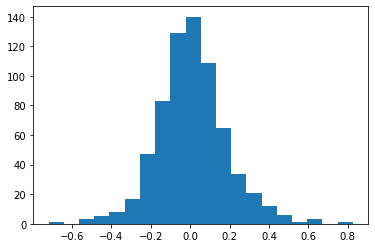

In [341]:
plt.hist(y_pred-y_test,bins=20)

### Feature Selection for Goalkeepers

In [342]:
from sklearn.feature_selection import SelectFromModel
def select_features(X_train, y_train, X_test):
    # configure to select all features
    fs = SelectFromModel(xg.XGBRegressor(n_estimators = 500))
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [343]:
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

[23:54:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [344]:
feature_names = X_train.columns[fs.get_support()]
print(feature_names)

Index(['age', 'gk_diving', 'gk_handling', 'gk_reflexes', 'gk_positioning'], dtype='object')


Feature 0 (age): 0.043962
Feature 1 (height_cm): 0.000515
Feature 2 (weight_kg): 0.000465
Feature 3 (gk_diving): 0.234929
Feature 4 (gk_handling): 0.121342
Feature 5 (gk_kicking): 0.011952
Feature 6 (gk_reflexes): 0.472262
Feature 7 (gk_speed): 0.000762
Feature 8 (gk_positioning): 0.078154
Feature 9 (movement_acceleration): 0.000608
Feature 10 (movement_sprint_speed): 0.000818
Feature 11 (movement_agility): 0.000681
Feature 12 (movement_reactions): 0.026289
Feature 13 (movement_balance): 0.000877
Feature 14 (power_shot_power): 0.000000
Feature 15 (power_jumping): 0.000688
Feature 16 (power_stamina): 0.001215
Feature 17 (power_strength): 0.000798
Feature 18 (power_long_shots): 0.000783
Feature 19 (mentality_vision): 0.000703
Feature 20 (mentality_penalties): 0.000697
Feature 21 (mentality_composure): 0.001003
Feature 22 (number_of_traits): 0.000497


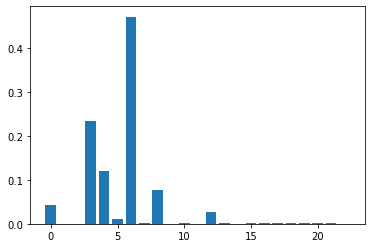

In [345]:
# what are scores for the features
for i in range(len(fs.estimator_.feature_importances_)):
	print('Feature %d (%s): %f' % (i, X.columns[i], fs.estimator_.feature_importances_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.estimator_.feature_importances_))], fs.estimator_.feature_importances_)
plt.show()

### Display Measures for Goalkeepers

In [346]:
gk_mse_all = [gk_mse_rf, gk_mse_xgb]
gk_rmse_all = [gk_rmse_rf, gk_rmse_xgb]
gk_mae_all = [gk_mae_rf, gk_mae_xgb]
gk_mape_all = [gk_mape_rf, gk_mape_xgb]

gk_mse_all = [round(num, 3) for num in gk_mse_all]
gk_rmse_all = [round(num, 3) for num in gk_rmse_all]
gk_mae_all = [round(num, 3) for num in gk_mae_all]
gk_mape_all = [round(num, 3) for num in gk_mape_all]

method = ["Random Forest", 'XGBoost']

overview = PrettyTable()

overview.add_column('Method', method)
overview.add_column("MSE", gk_mse_all)
overview.add_column("RMSE", gk_rmse_all)
overview.add_column("MAE", gk_mae_all)
overview.add_column("MAPE", gk_mape_all)

print(overview)

+---------------+-------+-------+-------+-------+
|     Method    |  MSE  |  RMSE |  MAE  |  MAPE |
+---------------+-------+-------+-------+-------+
| Random Forest | 0.074 | 0.272 |  0.2  | 0.016 |
|    XGBoost    | 0.031 | 0.177 | 0.132 |  0.01 |
+---------------+-------+-------+-------+-------+


## Random Forest Regressor for Field Players

In [347]:
#the data and target are set for the field players as they have different features
X = field_df.drop(["value_eur"],axis=1)
y = field_df.value_eur

In [348]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 1/3, random_state = 42)

In [349]:
#hyperparameter tuning dictionary initiated
tuned_parameters = {'n_estimators': [100, 200], 'max_depth': [None, 1, 2], 'criterion': ['mse']}
#hyperparameter tuning performed
clf = GridSearchCV(RandomForestRegressor(random_state=0), tuned_parameters, cv=3)

In [350]:
#the best model is fit to the train data
clf.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=0),
             param_grid={'criterion': ['mse'], 'max_depth': [None, 1, 2],
                         'n_estimators': [100, 200]})

In [351]:
#the best model hyperparameters
clf.best_params_

{'criterion': 'mse', 'max_depth': None, 'n_estimators': 200}

In [352]:
#test values are predicted with the trained model
y_pred=clf.predict(X_test)
#some metrics are output
mean_squared_error(y_test,y_pred,squared=True), mean_squared_error(y_test,y_pred,squared=False)

(0.08655123785797156, 0.2941959174733252)

In [353]:
cv_scores = cross_val_score(clf,X_train,y_train,cv=3)
print(cv_scores)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[0.94606229 0.94794841 0.94528821]
Average 5-Fold CV Score: 0.9464329708244014


In [354]:
y_pred = clf.predict(X_test)

In [355]:
y_test_pred = pd.Series(y_pred)
y_test_pred_real=np.e**y_test_pred

In [356]:
y_test_real=np.e**y_test

In [357]:
list_of_indexes = list(y_test.index)
list_of_predictions = list(y_test_pred_real)
list_total = list(zip(list_of_indexes, list(y_test_real), list_of_predictions))
df = pd.DataFrame(list_total, columns = ['index', 'true', 'pred'])

In [358]:
df

,index,true,pred
0,10872,675000.0,5.833882e+05
1,10388,425000.0,4.240667e+05
2,8463,875000.0,6.607165e+05
3,10711,800000.0,5.941271e+05
4,5928,825000.0,1.096433e+06
...,...,...,...
5546,9238,475000.0,4.574651e+05
5547,5757,1100000.0,1.188827e+06
5548,15477,275000.0,2.909943e+05
5549,1573,8000000.0,4.320567e+06


In [359]:
field_mse_rf = mean_squared_error(y_test,y_pred,squared=True)
field_rmse_rf = mean_squared_error(y_test,y_pred,squared=False)
field_mae_rf = mean_absolute_error(y_test,y_pred)
field_mape_rf = mean_absolute_percentage_error(y_test,y_pred)
field_r2_rf = np.mean(cv_scores)

In [360]:
field_mse_rf, field_rmse_rf

(0.08655123785797156, 0.2941959174733252)

In [361]:
#adding two columns to the new datadrame for evaluation. Difference column is for the absolute difference between the real and predicted values.
df["Difference"] = df.pred-df.true
#the different percentage column is for the percentage difference between the real and predicted values.
df['Difference %'] = 100*(df.pred-df.true)/df.true

In [362]:
name_list = []
for index in list(y_test.index):
    if index in field_dict:
        name_list.append(field_dict[index])
    else:
        break
df['player'] = name_list
col = df.pop("player")
df.insert(0, col.name, col)

In [363]:
age_list = []
for index in list(y_test.index):
    if index in field_age_dict:
        age_list.append(field_age_dict[index])
    else:
        break
df['age'] = age_list
col = df.pop("age")
df.insert(0, col.name, col)

In [364]:
df.sort_values(by='Difference',ascending=False)

,age,player,index,true,pred,Difference,Difference %
2206,26,Kerem Demirbay,425,17000000.0,2.855140e+07,1.155140e+07,67.949383
3808,35,Fernando Luiz Rosa,120,9500000.0,1.928348e+07,9.783475e+06,102.983952
3184,29,Antoine Griezmann,45,50500000.0,5.984220e+07,9.342202e+06,18.499409
1032,26,Francisco Alcácer García,309,21000000.0,3.008836e+07,9.088365e+06,43.277927
4046,24,Lucas Hernández Pi,214,26500000.0,3.521498e+07,8.714980e+06,32.886715
...,...,...,...,...,...,...,...
5158,30,Toni Kroos,24,55000000.0,3.109414e+07,-2.390586e+07,-43.465207
2715,24,Rodrigo Hernández Cascante,74,44000000.0,1.833569e+07,-2.566431e+07,-58.327989
1672,25,Joshua Kimmich,20,65000000.0,3.843680e+07,-2.656320e+07,-40.866465
3199,26,Harry Kane,21,71000000.0,4.298473e+07,-2.801527e+07,-39.458129


In [365]:
#sorting the percentage difference for final evaluation
df.sort_values(by='Difference %',ascending=False)

,age,player,index,true,pred,Difference,Difference %
987,38,吴庆,15817,30000.0,1.502057e+05,1.202057e+05,400.685768
4699,30,Maximiliano Francisco Lugo,8194,700000.0,2.758296e+06,2.058296e+06,294.042279
5133,23,Jae won Lee,18428,60000.0,2.352760e+05,1.752760e+05,292.126643
5308,38,Raffaele Cretaro,17216,30000.0,1.170483e+05,8.704831e+04,290.161028
1603,28,Nuno Caio Cedrim Feitosa,9295,650000.0,2.510835e+06,1.860835e+06,286.282289
...,...,...,...,...,...,...,...
4056,24,Emmanuel Okyere Boateng,1172,11000000.0,4.406355e+06,-6.593645e+06,-59.942230
564,21,Alberto Soro Álvarez,4437,3400000.0,1.264803e+06,-2.135197e+06,-62.799913
1803,18,Facundo Pellistri Rebollo,3727,4900000.0,1.766458e+06,-3.133542e+06,-63.949841
3304,20,Roberto Carlos Fernández Toro,12830,625000.0,2.137012e+05,-4.112988e+05,-65.807810


(array([4.000e+00, 1.200e+01, 4.700e+01, 9.500e+01, 2.370e+02, 4.660e+02,
        9.070e+02, 1.111e+03, 1.050e+03, 7.240e+02, 4.400e+02, 2.360e+02,
        1.000e+02, 6.000e+01, 3.300e+01, 1.600e+01, 7.000e+00, 1.000e+00,
        4.000e+00, 1.000e+00]),
 array([-1.07985749, -0.94532419, -0.81079089, -0.67625759, -0.54172429,
        -0.40719099, -0.27265769, -0.13812439, -0.00359109,  0.13094221,
         0.26547551,  0.40000881,  0.53454211,  0.66907541,  0.80360871,
         0.93814201,  1.07267531,  1.20720861,  1.34174191,  1.47627521,
         1.61080851]),
 <BarContainer object of 20 artists>)

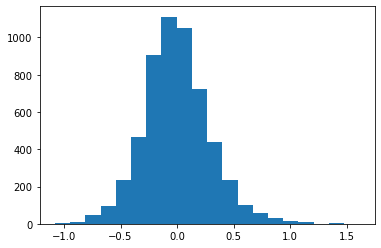

In [366]:
plt.hist(y_pred-y_test,bins=20)

### XGBoost Regression for Field Players

In [367]:
xgb2 = xg.XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [0.01,0.03,.05, 0.7], #so called `eta` value
              'max_depth': [4,5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500],
                'reg_alpha': [0,1,2]}


xgb_grid2 = GridSearchCV(xgb2,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid2.fit(X_train, y_train,early_stopping_rounds=10, eval_set=[(X_test, y_test)])

Fitting 2 folds for each of 48 candidates, totalling 96 fits
[0]	validation_0-rmse:12.5319
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:11.9085
[2]	validation_0-rmse:11.316
[3]	validation_0-rmse:10.7541
[4]	validation_0-rmse:10.2189
[5]	validation_0-rmse:9.71112
[6]	validation_0-rmse:9.228
[7]	validation_0-rmse:8.76922
[8]	validation_0-rmse:8.33369
[9]	validation_0-rmse:7.91946
[10]	validation_0-rmse:7.52573
[11]	validation_0-rmse:7.15277
[12]	validation_0-rmse:6.7982
[13]	validation_0-rmse:6.4611
[14]	validation_0-rmse:6.14112
[15]	validation_0-rmse:5.83719
[16]	validation_0-rmse:5.54846
[17]	validation_0-rmse:5.27393
[18]	validation_0-rmse:5.01367
[19]	validation_0-rmse:4.76638
[20]	validation_0-rmse:4.53143
[21]	validation_0-rmse:4.30824
[22]	validation_0-rmse:4.09581
[23]	validation_0-rmse:3.89438
[24]	validation_0-rmse:3.70289
[25]	validation_0-rmse:3.52121
[26]	validation_0-rmse:3.34944
[27]	validation_0-rmse:3.18525
[28]	validation_0-rms

[251]	validation_0-rmse:0.23783
[252]	validation_0-rmse:0.237695
[253]	validation_0-rmse:0.237536
[254]	validation_0-rmse:0.237258
[255]	validation_0-rmse:0.237176
[256]	validation_0-rmse:0.236927
[257]	validation_0-rmse:0.236736
[258]	validation_0-rmse:0.23668
[259]	validation_0-rmse:0.236615
[260]	validation_0-rmse:0.236534
[261]	validation_0-rmse:0.23636
[262]	validation_0-rmse:0.236318
[263]	validation_0-rmse:0.236129
[264]	validation_0-rmse:0.236086
[265]	validation_0-rmse:0.236
[266]	validation_0-rmse:0.235845
[267]	validation_0-rmse:0.23569
[268]	validation_0-rmse:0.235516
[269]	validation_0-rmse:0.235375
[270]	validation_0-rmse:0.235299
[271]	validation_0-rmse:0.235172
[272]	validation_0-rmse:0.235071
[273]	validation_0-rmse:0.23493
[274]	validation_0-rmse:0.234773
[275]	validation_0-rmse:0.234668
[276]	validation_0-rmse:0.234558
[277]	validation_0-rmse:0.234461
[278]	validation_0-rmse:0.234359
[279]	validation_0-rmse:0.23425
[280]	validation_0-rmse:0.234184
[281]	validation_0-

GridSearchCV(cv=2, estimator=XGBRegressor(), n_jobs=5,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.01, 0.03, 0.05, 0.7],
                         'max_depth': [4, 5, 6, 7], 'min_child_weight': [4],
                         'n_estimators': [500], 'nthread': [4],
                         'objective': ['reg:squarederror'],
                         'reg_alpha': [0, 1, 2], 'silent': [1],
                         'subsample': [0.7]},
             verbose=True)

In [368]:
y_pred=xgb_grid2.predict(X_test)

In [369]:
field_mse_xgb = mean_squared_error(y_test,y_pred,squared=True)
field_rmse_xgb = mean_squared_error(y_test,y_pred,squared=False)
field_mae_xgb = mean_absolute_error(y_test,y_pred)
field_mape_xgb = mean_absolute_percentage_error(y_test,y_pred)
field_r2_xgb = xgb_grid2.best_estimator_.score(X_test,y_test)
field_mse_xgb, field_rmse_xgb

(0.04996756430235896, 0.2235342575587889)

In [370]:
y_pred_real=np.e**y_pred

In [371]:
list_of_indexes = list(y_test.index)
list_of_predictions = list(y_pred_real)
list_total = list(zip(list_of_indexes, list(y_test_real), list_of_predictions))
df_field_xgb = pd.DataFrame(list_total, columns = ['index', 'true', 'pred'])

In [372]:
#adding two columns to the new datadrame for evaluation. Difference column is for the absolute difference between the real and predicted values.
df_field_xgb["Difference"] = df_field_xgb.pred-df_field_xgb.true
#the different percentage column is for the percentage difference between the real and predicted values.
df_field_xgb['Difference %'] = 100*(df_field_xgb.pred-df_field_xgb.true)/df_field_xgb.true

In [373]:
name_list = []
for index in list(y_test.index):
    if index in field_dict:
        name_list.append(field_dict[index])
    else:
        break
df_field_xgb['player'] = name_list
col = df_field_xgb.pop("player")
df_field_xgb.insert(0, col.name, col)

In [374]:
age_list = []
for index in list(y_test.index):
    if index in field_age_dict:
        age_list.append(field_age_dict[index])
    else:
        break
df_field_xgb['age'] = age_list
col = df_field_xgb.pop("age")
df_field_xgb.insert(0, col.name, col)

In [375]:
df_field_xgb.sort_values(by='Difference',ascending=False)

,age,player,index,true,pred,Difference,Difference %
4590,27,손흥민 孙兴慜,46,52500000.0,73388656.0,20888656.0,39.787916
4046,24,Lucas Hernández Pi,214,26500000.0,42771396.0,16271396.0,61.401494
2248,32,Alejandro Darío Gómez,51,34500000.0,48281164.0,13781164.0,39.945403
3049,31,Charles Mariano Aránguiz Sandoval,195,19500000.0,29971310.0,10471310.0,53.699026
3184,29,Antoine Griezmann,45,50500000.0,60899148.0,10399148.0,20.592372
...,...,...,...,...,...,...,...
4551,27,Paul Pogba,49,50000000.0,31620468.0,-18379532.0,-36.759064
1672,25,Joshua Kimmich,20,65000000.0,46035688.0,-18964312.0,-29.175865
104,28,Neymar da Silva Santos Júnior,4,90000000.0,69035288.0,-20964712.0,-23.294124
2482,33,Lionel Andrés Messi Cuccittini,0,67500000.0,41039124.0,-26460876.0,-39.201298


In [376]:
df_field_xgb[df_field_xgb['age']<23].sort_values(by='Difference',ascending=False)

,age,player,index,true,pred,Difference,Difference %
4846,22,Pol Mikel Lirola Kosok,3890,3200000.0,7123299.0,3923299.0,122.603094
2962,21,Mike Trésor Ndayishimiye,3079,4600000.0,7888910.0,3288910.0,71.498043
1225,21,Riley McGree,3818,3300000.0,6242737.0,2942737.0,89.173848
1814,22,Orel Mangala,3070,4500000.0,7137545.5,2637545.5,58.612122
1758,20,Cristian Ezequiel Ferreira,4466,3000000.0,5522784.0,2522784.0,84.092800
...,...,...,...,...,...,...,...
976,22,Aaron Wan-Bissaka,149,30500000.0,23635390.0,-6864610.0,-22.506918
4405,20,Ferran Torres García,276,26500000.0,17120514.0,-9379486.0,-35.394287
1508,21,Kai Havertz,62,57000000.0,46067836.0,-10932164.0,-19.179235
2347,21,Martin Ødegaard,141,36000000.0,22802014.0,-13197986.0,-36.661072


In [377]:
#sorting the percentage difference for final evaluation
df_field_xgb.sort_values(by='Difference %',ascending=False)

,age,player,index,true,pred,Difference,Difference %
2039,25,Paulo Henrique Soares dos Santos,5619,1300000.0,4.794102e+06,3.494102e+06,268.777038
3373,24,Helio Paulo Caldeira Andrade,7106,850000.0,2.694947e+06,1.844947e+06,217.052588
1603,28,Nuno Caio Cedrim Feitosa,9295,650000.0,1.911636e+06,1.261636e+06,194.097865
987,38,吴庆,15817,30000.0,8.399120e+04,5.399120e+04,179.970651
3687,19,蒋圣龙,18200,90000.0,2.505924e+05,1.605924e+05,178.436007
...,...,...,...,...,...,...,...
3304,20,Roberto Carlos Fernández Toro,12830,625000.0,3.056544e+05,-3.193456e+05,-51.095290
4367,20,Santiago Moreno,14523,450000.0,2.179763e+05,-2.320237e+05,-51.560826
1327,31,Antonio Bareiro Álvarez,4411,2100000.0,9.914345e+05,-1.108565e+06,-52.788833
3414,28,Eduardo Ramos Gómez,4793,1800000.0,8.338944e+05,-9.661056e+05,-53.672531


In [378]:
df_field_xgb[df_field_xgb['age']<23][df_field_xgb['true']>1000000].sort_values(by='Difference %',ascending=False)

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,age,player,index,true,pred,Difference,Difference %
4109,22,Víctor Alejandro Dávila Zavala,7397,1100000.0,2950007.75,1850007.75,168.182523
3772,22,Ibrahima Sissoko,5371,1600000.0,3685435.50,2085435.50,130.339719
4846,22,Pol Mikel Lirola Kosok,3890,3200000.0,7123299.00,3923299.00,122.603094
3950,20,Romano Schmid,7213,1300000.0,2776209.25,1476209.25,113.554558
1225,21,Riley McGree,3818,3300000.0,6242737.00,2942737.00,89.173848
...,...,...,...,...,...,...,...
688,22,Jordan Torunarigha,1478,10000000.0,5618214.00,-4381786.00,-43.817860
5017,19,Heorhii Tsitaishvili,2996,6500000.0,3625050.50,-2874949.50,-44.229992
4306,22,Anthony Roberth Osorio Del Rosario,8370,1100000.0,605756.50,-494243.50,-44.931227
1542,21,Maximiliano Samuel Romero,3744,4100000.0,2247068.25,-1852931.75,-45.193457


(array([5.000e+00, 8.000e+00, 3.700e+01, 1.250e+02, 2.690e+02, 6.160e+02,
        1.028e+03, 1.199e+03, 9.800e+02, 6.290e+02, 3.110e+02, 1.610e+02,
        8.500e+01, 4.400e+01, 3.100e+01, 1.200e+01, 6.000e+00, 3.000e+00,
        1.000e+00, 1.000e+00]),
 array([-0.81674985, -0.71066123, -0.60457261, -0.49848399, -0.39239537,
        -0.28630675, -0.18021813, -0.07412951,  0.03195911,  0.13804773,
         0.24413635,  0.35022497,  0.45631359,  0.56240221,  0.66849083,
         0.77457945,  0.88066807,  0.98675669,  1.09284531,  1.19893393,
         1.30502255]),
 <BarContainer object of 20 artists>)

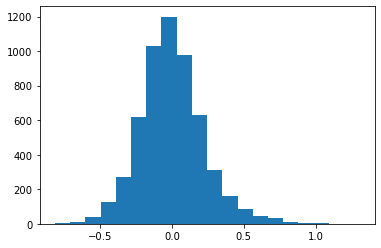

In [379]:
plt.hist(y_pred-y_test,bins=20)

#### Perform Feature Selection

In [380]:
X_train_fs, X_test_fs, sel = select_features(X_train, y_train, X_test)

[00:11:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [381]:
selected_feat= X_train.columns[(sel.get_support())]
print(selected_feat)

Index(['age', 'dribbling', 'defending', 'attacking_short_passing',
       'skill_dribbling', 'skill_ball_control', 'movement_sprint_speed',
       'movement_reactions', 'mentality_composure',
       'defending_standing_tackle', 'defending_sliding_tackle'],
      dtype='object')


Feature 0 (age): 0.033738
Feature 1 (height_cm): 0.000666
Feature 2 (weight_kg): 0.000634
Feature 3 (weak_foot): 0.000361
Feature 4 (skill_moves): 0.000876
Feature 5 (pace): 0.022359
Feature 6 (shooting): 0.012971
Feature 7 (passing): 0.002209
Feature 8 (dribbling): 0.115600
Feature 9 (defending): 0.057672
Feature 10 (physic): 0.021299
Feature 11 (attacking_crossing): 0.009982
Feature 12 (attacking_finishing): 0.012716
Feature 13 (attacking_heading_accuracy): 0.017487
Feature 14 (attacking_short_passing): 0.033953
Feature 15 (attacking_volleys): 0.002180
Feature 16 (skill_dribbling): 0.030422
Feature 17 (skill_curve): 0.000549
Feature 18 (skill_fk_accuracy): 0.001135
Feature 19 (skill_long_passing): 0.002077
Feature 20 (skill_ball_control): 0.150067
Feature 21 (movement_acceleration): 0.006264
Feature 22 (movement_sprint_speed): 0.025938
Feature 23 (movement_agility): 0.000701
Feature 24 (movement_reactions): 0.263519
Feature 25 (movement_balance): 0.000665
Feature 26 (power_shot_power

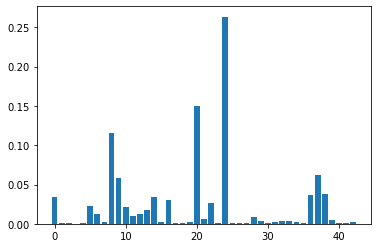

In [382]:
for i in range(len(sel.estimator_.feature_importances_)):
	print('Feature %d (%s): %f' % (i, X.columns[i], sel.estimator_.feature_importances_[i]))
# plot the scores
plt.bar([i for i in range(len(sel.estimator_.feature_importances_))], sel.estimator_.feature_importances_)
plt.show()

### Display Measures for All the Models

In [383]:
mse_all = [gk_mse_rf, gk_mse_xgb, field_mse_rf, field_mse_xgb]

In [384]:
rmse_all = [gk_rmse_rf, gk_rmse_xgb, field_rmse_rf, field_rmse_xgb]

In [385]:
mae_all = [gk_mae_rf,gk_mae_xgb, field_mae_rf, field_mae_xgb]

In [386]:
mape_all = [gk_mape_rf, gk_mape_xgb, field_mape_rf, field_mape_xgb]

In [387]:
r2_all = [gk_r2_rf, gk_r2_xgb, field_r2_rf, field_r2_xgb]

In [388]:
mse_all = [round(num, 4) for num in mse_all]
rmse_all = [round(num, 4) for num in rmse_all]
mae_all = [round(num, 4) for num in mae_all]
mape_all = [round(num, 4) for num in mape_all]
r2_all = [round(num, 4) for num in r2_all]

In [389]:
method = ["Random Forest GK", 'XGBoost GK',"Random Forest Field", 'XGBoost Field']

In [390]:
overview = PrettyTable()

In [391]:
overview.add_column('Method', method)
overview.add_column("MSE", mse_all)
overview.add_column("RMSE", rmse_all)
overview.add_column("MAE", mae_all)
overview.add_column("MAPE", mape_all)
overview.add_column("R SQUARED", r2_all)

In [392]:
print(overview)

+---------------------+--------+--------+--------+--------+-----------+
|        Method       |  MSE   |  RMSE  |  MAE   |  MAPE  | R SQUARED |
+---------------------+--------+--------+--------+--------+-----------+
|   Random Forest GK  | 0.0739 | 0.2718 | 0.1997 | 0.0157 |   0.9658  |
|      XGBoost GK     | 0.0314 | 0.1771 | 0.132  | 0.0104 |   0.9855  |
| Random Forest Field | 0.0866 | 0.2942 | 0.2245 | 0.0166 |   0.9464  |
|    XGBoost Field    |  0.05  | 0.2235 | 0.1694 | 0.0126 |   0.9732  |
+---------------------+--------+--------+--------+--------+-----------+


### Final Results

In [393]:
df_gk_final_perc = df_gk_xgb.nlargest(100,'Difference %')
df_gk_final_total = df_gk_xgb.nlargest(100,"Difference")
list_gk_topperc = list(df_gk_final_perc.player)
df_gk_final = df_gk_final_total[df_gk_final_total.player.isin(list_gk_topperc)]
df_gk_final["Position"] = "GK"

df_field_final_perc = df_field_xgb.nlargest(1000,'Difference %')
df_field_final_total = df_field_xgb.nlargest(1000,"Difference")
list_field_topperc = list(df_field_final_perc.player)
df_field_final = df_field_final_total[df_field_final_total.player.isin(list_field_topperc)]
df_field_final["Position"] = "FP"

final = df_gk_final.append(df_field_final, ignore_index=True)
final[(final.age <= 23) & (final.true >= 1000000)].sort_values(by="Difference",ascending=False)

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,age,player,index,true,pred,Difference,Difference %,Position
74,22,Pol Mikel Lirola Kosok,3890,3200000.0,7.123299e+06,3923299.000,122.603094,FP
84,21,Mike Trésor Ndayishimiye,3079,4600000.0,7.888910e+06,3288910.000,71.498043,FP
90,21,Riley McGree,3818,3300000.0,6.242737e+06,2942737.000,89.173848,FP
94,23,Lucas Gastón Robertone,1495,10000000.0,1.264031e+07,2640307.000,26.403070,FP
95,22,Orel Mangala,3070,4500000.0,7.137546e+06,2637545.500,58.612122,FP
...,...,...,...,...,...,...,...,...
443,23,Mads Pedersen,6457,1100000.0,1.373338e+06,273338.000,24.848909,FP
448,22,Dimitri Joseph Oberlin Mfomo,6392,1300000.0,1.568326e+06,268326.500,20.640500,FP
449,23,Thierry Ambrose,6348,1300000.0,1.568105e+06,268105.125,20.623471,FP
464,21,Joel Asoro,8376,1100000.0,1.358935e+06,258935.125,23.539557,FP


In [394]:
final.sort_values(by="Difference",ascending=False)[:30]

,age,player,index,true,pred,Difference,Difference %,Position
46,27,손흥민 孙兴慜,46,52500000.0,73388656.0,20888656.0,39.787916,FP
47,24,Lucas Hernández Pi,214,26500000.0,42771396.0,16271396.0,61.401494,FP
48,32,Alejandro Darío Gómez,51,34500000.0,48281164.0,13781164.0,39.945403,FP
49,31,Charles Mariano Aránguiz Sandoval,195,19500000.0,29971310.0,10471310.0,53.699026,FP
50,29,Antoine Griezmann,45,50500000.0,60899148.0,10399148.0,20.592372,FP
51,26,Kerem Demirbay,425,17000000.0,26796508.0,9796508.0,57.626518,FP
52,26,Raphaël Adelino José Guerreiro,116,36500000.0,45560316.0,9060316.0,24.822784,FP
53,31,Lars Stindl,453,13000000.0,21835036.0,8835036.0,67.961815,FP
54,27,Florian Thauvin,264,23000000.0,31471370.0,8471370.0,36.832043,FP
55,24,Jonathan Tah,514,15000000.0,23405296.0,8405296.0,56.035307,FP


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d0001f84-164c-454a-9f8a-a2e6174a5f5c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>